#### Báo cáo đồ án: PYTHON CHO KHOA HỌC DỮ LIỆU
#### Lớp 22TTH. Khoa Toán - Tin học
#### Đề tài: A/B TESTING IN OPTIMIZING ADS
#### Giảng viên bộ môn: ThS. Hà Văn Thảo
#### Thành viên nhóm:
1. 22110023 - Lâm Gia Bảo
2. 22110008 - Trần Duy An
3. 22110014 - Đậu Quang Anh
4. 22110035 - Trần Quốc Danh

## GIỚI THIỆU

Một thử nghiệm A/B (A/B Testing) đang được thực hiện bởi một nhà bán lẻ giày trực tuyến, trong đó họ đang kiểm tra hai phiên bản khác nhau của một quảng cáo. Các phiên bản quảng cáo này được hiển thị qua các nền tảng như Email, Facebook, Twitter và Google. Nhà bán lẻ muốn đánh giá hiệu suất của từng phiên bản quảng cáo trên các nền tảng khác nhau vào mỗi ngày trong tuần. Để hỗ trợ họ trong việc phân tích dữ liệu, nhóm sẽ sử dụng các chỉ số tổng hợp và kiểm định giả thuyết để đánh giá các chỉ số hiệu suất.

## KHAI BÁO DỮ LIỆU VÀ CÁC THƯ VIỆN CẦN THIẾT

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import math
import statistics
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
ad_clicks = pd.read_csv(r'ad_clicks.csv')

## TỔNG QUAN VỀ DỮ LIỆU ##

Ta dùng lệnh `info()` để kiểm tra các thông số tổng quan về dữ liệu này.

In [3]:
ad_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             1654 non-null   object
 1   utm_source          1654 non-null   object
 2   day                 1654 non-null   object
 3   ad_click_timestamp  565 non-null    object
 4   experimental_group  1654 non-null   object
dtypes: object(5)
memory usage: 64.7+ KB


Dựa vào kết quả trên, ta sẽ có tất cả 5 cột dữ liệu bao gồm: `user_id`, `utm_source`, `day`, `ad_click_timestamp`, `experimental_group`. Tất cả 5 cột ấy đều có kiểu dữ liệu là object (chuỗi). Ngoài ra ta có 1654 dòng dữ liệu trong file vừa đọc, riêng cột `ad_click_timestamp` có khoảng 1000 dòng giá trị bị khuyết.

**Mỗi cột dữ liệu có ý nghĩa gì?**
Dữ liệu có tổng cộng 5 cột, với các ý nghĩa cơ bản của từng cột như sau:

 1. `user_id`: Mã người dùng (định danh), là duy nhất.

 2. `utm_source`: Nền tảng của quảng cáo mà người dùng truy cập vào.

 3. `day`: Ngày mà hành động truy cập vào quảng cáo xảy ra.

 4. `ad_click_timestamp`: Thời điểm khi người dùng nhấp chuột vào quảng cáo.

 5. `experimental_group`: Nhóm thử nghiệm mà người dùng tham gia trong thử nghiệm (cụ thể là phiên bản quảng cáo mà người dùng đã xem).

Tiếp theo, ta xem qua vài dòng đầu tiên của bộ dữ liệu.

In [4]:
ad_clicks.head(10)

,user_id,utm_source,day,ad_click_timestamp,experimental_group
0,008b7c6c-7272-471e-b90e-930d548bd8d7,google,6 - Saturday,07:18:00,A
1,009abb94-5e14-4b6c-bb1c-4f4df7aa7557,facebook,7 - Sunday,NaN,B
2,00f5d532-ed58-4570-b6d2-768df5f41aed,twitter,2 - Tuesday,NaN,A
3,011adc64-0f44-4fd9-a0bb-f1506d2ad439,google,2 - Tuesday,NaN,B
4,012137e6-7ae7-4649-af68-205b4702169c,facebook,7 - Sunday,NaN,B
5,013b0072-7b72-40e7-b698-98b4d0c9967f,facebook,1 - Monday,NaN,A
6,0153d85b-7660-4c39-92eb-1e1acd023280,google,4 - Thursday,NaN,A
7,01555297-d6e6-49ae-aeba-1b196fdbb09f,google,3 - Wednesday,NaN,A
8,018cea61-19ea-4119-895b-1a4309ccb148,email,1 - Monday,18:33:00,A
9,01a210c3-fde0-4e6f-8efd-4f0e38730ae6,email,2 - Tuesday,15:21:00,B


In [5]:
ad_clicks.nunique()

,0
user_id,1654
utm_source,4
day,7
ad_click_timestamp,464
experimental_group,2


Ta cũng dùng lệnh `nunique()` để kiểm tra số lượng các giá trị duy nhất của dữ liệu. Ở đây ta thấy:

1. Cột `user_id` có 1654 giá trị duy nhất (vì như đã nói ở trên, user_id của mỗi người là duy nhất).

2. Cột `utm_source` có 4 giá trị duy nhất (google, facebook, twitter, email).

3. Cột `day` có 7 giá trị duy nhất (Từ Thứ hai (1 - Monday) đến Chủ nhật (7 - Sunday)).

4. Cột `ad_click_timestamp` có 464 giá trị duy nhất.

5. Cột `experimental_group` có 2 giá trị duy nhất (A và B).

Tiếp theo, ta dùng lệnh `duplicated()` để xem có giá trị nào bị trùng trong bộ dữ liệu hay không.

In [6]:
ad_clicks.duplicated().sum()

np.int64(0)

Kết quả cho ta thấy không có giá trị bị trùng (dupicated values).

###  Nền tảng quảng cáo nào mang lại nhiều lượt xem nhất?
Mỗi một `utm_source` mang lại bao nhiêu lượt xem (tức là bao nhiêu dòng trong bảng)?

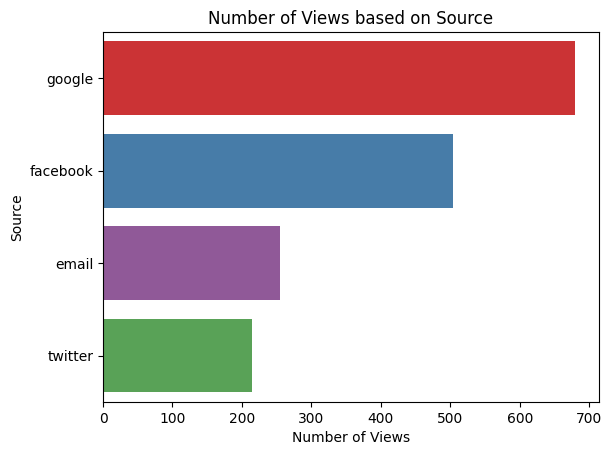

In [7]:
sns.countplot(data = ad_clicks, y = 'utm_source', order = ad_clicks['utm_source'].value_counts().index,
              palette = sns.color_palette("Set1", 4), hue = 'utm_source')
plt.title('Number of Views based on Source')
plt.xlabel('Number of Views')
plt.ylabel('Source')
plt.yticks(rotation = 0)
plt.show()

Đây là biểu đồ cột hiển thị số lượng dữ liệu cho từng giá trị duy nhất trong cột `utm_source` và có sắp xếp theo thứ tự giảm dần các giá trị. Trong đó, Google là nền tảng có số lượt xem cao nhất với gần 700 lượt, Twitter là nền tảng có số lượt xem thấp nhất với hơn 200 lượt.

## KIỂM ĐỊNH GIẢ THUYẾT

### Đặt câu hỏi:
Khi khám phá dữ liệu trên, kết hợp với thống kê mô tả, ta đưa ra được hai giả thuyết để có thể kiểm định như sau:

1. **Giả thuyết 1:** Tỷ lệ chuyển đổi giữa các `utm_source` có sự khác biệt đáng kể hay không?

3. **Giả thuyết 2:** Có sự khác biệt giữa tỷ lệ của hai quảng cáo ở nhóm A và B hay không?

### Giả thuyết 1: Tỷ lệ chuyển đổi giữa các `utm_source` có sự khác biệt đáng kể hay không?
Giả thuyết này là một kiểm định A/B với 4 `utm_source` (4 nền tảng) khác nhau. Điều ta quan tâm ở đây là khách hàng có khả năng truy cập vào quảng cáo nhiều hơn hoặc ít hơn nếu họ truy cập quảng cáo của một trong các nền tảng khác hay không?

Ta có cặp giả thuyết - đối thuyết đầu tiên:

- **Giả thuyết không $(H_0)$**: Không có sự khác biệt về tỷ lệ chuyển đổi giữa các `utm_source`.

- **Đối thuyết $(H_1)$**: Có sự khác biệt về tỷ lệ chuyển đổi giữa các `utm_source`.

Để có được câu trả lời cho điều trên, ta sẽ sử dụng phương pháp Kiểm định Chi bình phương (*Chi-square's Test for Independence*) với mức ý nghĩa $\alpha = 5\% = 0.05$.

Đầu tiên ta thực hiện vẽ bảng chéo (cross table) đối với hai biến phân loại là `utm_source` và `ad_click_timestamp`. Đối với `ad_click_timestamp` ta thực hiện chia ra thành 2 bộ dữ liệu là `True` đối với dữ liệu không khuyết, `False` đối với dữ liệu bị khuyết (*NA*).

In [8]:
# Crosstable
ad_clicks.ad_click_timestamp.isnull()
Xtab = pd.crosstab(ad_clicks.utm_source, ad_clicks.ad_click_timestamp.isnull())

In [9]:
# Crosstable with click_percentage
Crosstable_with_percentage = Xtab
Crosstable_with_percentage['click_percentage'] = (Xtab[False])/(Xtab[True]+Xtab[False])

In [10]:
Crosstable_with_percentage

ad_click_timestamp,False,True,click_percentage
utm_source,,,
email,80,175,0.313725
facebook,180,324,0.357143
google,239,441,0.351471
twitter,66,149,0.306977


Ta sẽ dùng hàm `chi2_contingency()`:

In [11]:
chi2, p_value, dof, expected = stats.chi2_contingency(Xtab)
print(f'p-value: {p_value: .4f}')
if p_value <= 0.05:
    print('Bác bỏ H0')
else:
    print('Chưa đủ cơ sở bác bỏ H0')

p-value:  0.7963
Chưa đủ cơ sở bác bỏ H0


Với $p_{value} = 0.7963$ > $\alpha = 0.05$ thì ta kết luận là Chưa đủ cơ sở bác bỏ H0.

Vậy với mức ý nghĩa $\alpha = 0.05$ ta kết luận rằng Không có sự khác biệt về tỷ lệ chuyển đổi giữa các `utm_source`.

### Giả thuyết 2: Có sự khác biệt giữa tỷ lệ xem của hai quảng cáo ở nhóm A và B hay không?
Điều ta quan tâm ở đây là khách hàng có khả năng truy cập vào quảng cáo ở nhóm còn lại nhiều hơn hay không?

Ta có cặp giả thuyết - đối thuyết thứ hai:

- **Giả thuyết không $(H_0)$**: Không có sự khác biệt giữa tỷ lệ truy cập của hai quảng cáo ở nhóm A và B.

- **Đối thuyết $(H_1)$**: Có sự khác biệt giữa tỷ lệ truy cập của hai quảng cáo ở nhóm A và B.

Một lần nữa, ta sẽ sử dụng phương pháp Kiểm định Chi bình phương với mức ý nghĩa $\alpha = 5\% = 0.05$ để kiểm định điều đó.

Ta cũng thực hiện vẽ bảng chéo (cross table) đối với hai biến phân loại là `experimental_group` và `ad_click_timestamp`. Tương tự như trên, đối với `ad_click_timestamp` ta cũng thực hiện chia ra thành 2 bộ dữ liệu là `True` đối với dữ liệu không khuyết, `False` đối với dữ liệu bị khuyết (*NA*).

In [12]:
ads_a = ad_clicks[ad_clicks.experimental_group == 'A']
ads_b = ad_clicks[ad_clicks.experimental_group == 'B']
crosstab_ab = pd.crosstab(ad_clicks.experimental_group, ad_clicks.ad_click_timestamp.isnull())

In [13]:
crosstab_ab
#crosstab_ab[True][0]

ad_click_timestamp,False,True
experimental_group,,
A,310,517
B,255,572


Ta lại dùng hàm `chi2_contingency()`:

In [14]:
chi2, p_value, dof, expected = stats.chi2_contingency(crosstab_ab)
print(f'p-value: {p_value: .4f}')

if p_value <= 0.05:
    print('Bác bỏ H0')
else:
    print('Không bác bỏ H0')

p-value:  0.0051
Bác bỏ H0


Với $p_{value} = 0.0051$ < $\alpha = 0.05$ thì ta kết luận Bác bỏ H0.

Như kết quả từ kiểm định giả thuyết trên cho ta thấy, sự khác biệt giữa tỷ lệ chuyển đổi giữa hai quảng cáo A và B là có ý nghĩa và không phải do ngẫu nhiên. Từ đó, chúng ta có thể tiếp tục với các giai đoạn tiếp theo của việc phân tích.

## PHÂN TÍCH DỮ LIỆU CHO TỪNG NỀN TẢNG QUẢNG CÁO

### Tạo cột mới tên `is_click`
Nếu như 1 giá trị nào đó trong cột `ad_click_timestamp` không bị khuyết, tức là quảng cáo đã được nhấp chuột truy cập vào. Để thuận tiện cho các bước phân tích tiếp theo, ta sẽ tạo cột `is_click` nhận giá trị **True** nếu giá trị tại cột `ad_click_timestamp` tương ứng không bị khuyết, và **False** nếu ngược lại.

In [15]:
ad_clicks['is_click'] = ad_clicks.ad_click_timestamp.notnull()

In [16]:
ad_clicks.head(10)

,user_id,utm_source,day,ad_click_timestamp,experimental_group,is_click
0,008b7c6c-7272-471e-b90e-930d548bd8d7,google,6 - Saturday,07:18:00,A,True
1,009abb94-5e14-4b6c-bb1c-4f4df7aa7557,facebook,7 - Sunday,NaN,B,False
2,00f5d532-ed58-4570-b6d2-768df5f41aed,twitter,2 - Tuesday,NaN,A,False
3,011adc64-0f44-4fd9-a0bb-f1506d2ad439,google,2 - Tuesday,NaN,B,False
4,012137e6-7ae7-4649-af68-205b4702169c,facebook,7 - Sunday,NaN,B,False
5,013b0072-7b72-40e7-b698-98b4d0c9967f,facebook,1 - Monday,NaN,A,False
6,0153d85b-7660-4c39-92eb-1e1acd023280,google,4 - Thursday,NaN,A,False
7,01555297-d6e6-49ae-aeba-1b196fdbb09f,google,3 - Wednesday,NaN,A,False
8,018cea61-19ea-4119-895b-1a4309ccb148,email,1 - Monday,18:33:00,A,True
9,01a210c3-fde0-4e6f-8efd-4f0e38730ae6,email,2 - Tuesday,15:21:00,B,True


### Tỷ lệ người dùng nhấp chuột vào quảng cáo trên từng nền tảng
Mục tiêu để xác định tỷ lệ phần trăm một người nhấp chuột vào quảng cáo của từng nền tảng trong `utm_source`. Để làm được điều đó, ta sẽ bắt đầu với việc nhóm dữ liệu dựa trên hai biến `utm_source` và `is_click`, sau đó tính toán số lượng `user_id` trên mỗi nhóm. Kết quả thu được sẽ lưu vào một biến mới tên `clicks_by_source`.

In [17]:
clicks_by_source = ad_clicks.groupby(['utm_source', 'is_click']).user_id.count().reset_index()

In [18]:
clicks_by_source

,utm_source,is_click,user_id
0,email,False,175
1,email,True,80
2,facebook,False,324
3,facebook,True,180
4,google,False,441
5,google,True,239
6,twitter,False,149
7,twitter,True,66


In [19]:
clicks_by_source['user_id'].sum()

np.int64(1654)

### Tạo một bảng tổng hợp nhấp chuột
Ta sẽ tạo một bảng tổng hợp tên `clicks_pivot` với các cột lấy từ `is_click` (gồm True và False); các index lấy từ `utm_source` (gồm email, facebook, google và twitter); và các giá trị trong bảng được lấy từ `user_id` của `click_by_source`.

In [20]:
clicks_pivot = clicks_by_source.pivot(columns='is_click',index='utm_source',values='user_id').reset_index()
clicks_pivot

is_click,utm_source,False,True
0,email,175,80
1,facebook,324,180
2,google,441,239
3,twitter,149,66


### Thêm cột tỷ lệ nhấp chuột vào bảng tổng hợp
Ta tạo thêm 1 cột tên `percent_clicked` trong bảng để đại diện cho tỷ lệ người dùng nhấp chuột giữa các quảng cáo chạy trên các nền tảng khác nhau. Tỷ lệ nhấp chuột trên mỗi nền tảng sẽ được so sánh với nhau.

In [21]:
clicks_pivot['percent_clicked'] = clicks_pivot[True] /(clicks_pivot[True] + clicks_pivot[False])

In [22]:
clicks_pivot

is_click,utm_source,False,True,percent_clicked
0,email,175,80,0.313725
1,facebook,324,180,0.357143
2,google,441,239,0.351471
3,twitter,149,66,0.306977


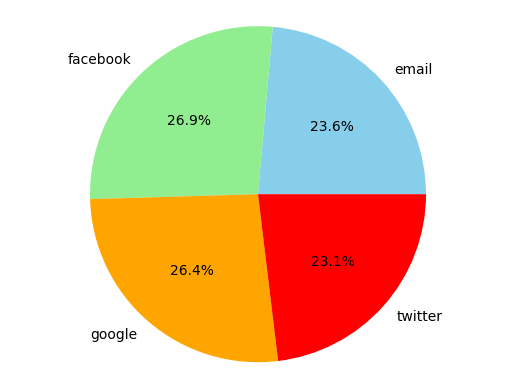

<Figure size 640x480 with 0 Axes>

In [23]:
# A pie chart for comparison
clicks_pivot_wedge_sizes = clicks_pivot.percent_clicked
clicks_pivot_wedge_labels = clicks_pivot.utm_source

plt.pie(clicks_pivot_wedge_sizes, labels = clicks_pivot_wedge_labels, colors=['skyblue','lightgreen','orange','red'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()
plt.clf()

Dựa vào bảng tổng hợp và cả biểu đồ tròn, ta có thể thấy mặc dù nền tảng Google mang lại nhiều lượt xem quảng cáo nhất, nhưng quảng cáo chạy trên nền tảng Facebook mới chiếm tỷ lệ nhấp chuột cao nhất trong chiến dịch quảng cáo này, kế đến là nền tảng Google, Email và cuối cùng là Twitter.

Để cho dự đoán này chính xác hơn, ta sẽ dùng phương pháp kiểm định so sánh từng cặp tỷ lệ Facebook với các nền tảng khác.

In [24]:
total = [clicks_pivot[False][i] + clicks_pivot[True][i] for i in range(4)]

In [25]:
facebook_true = clicks_pivot[True][1]
facebook_total = total[1]

Ta sẽ dùng vòng lặp for lặp hết cả 3 nền tảng còn lại và kiểm định sự khác nhau về tỷ lệ nhấp chuột của chúng so với Facebook, với giả thuyết chính yếu cho rằng tỷ lệ truy cập quảng cáo của nền tảng Facebook nhiều hơn tất cả các nền tảng khác.

In [26]:
for i, source in enumerate(clicks_pivot['utm_source']):
    if source == 'facebook':
        continue
    other_true = clicks_pivot[True][i]
    other_total = total[i]
    z_stat, p_value = sm.stats.proportions_ztest([facebook_true, other_true], [facebook_total, other_total])

    print(f"H0: Tỷ lệ truy cập quảng cáo của nền tảng facebook nhiều hơn nền tảng {source}:")
    print(f"- Z-statistic: {z_stat:.4f}")
    print(f"- P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Bác bỏ giả thuyết H0\n")
    else:
        print("Chưa đủ cơ sở bác bỏ giả thuyết H0\n")

H0: Tỷ lệ truy cập quảng cáo của nền tảng facebook nhiều hơn nền tảng email:
- Z-statistic: 1.1905
- P-value: 0.2338
Chưa đủ cơ sở bác bỏ giả thuyết H0

H0: Tỷ lệ truy cập quảng cáo của nền tảng facebook nhiều hơn nền tảng google:
- Z-statistic: 0.2018
- P-value: 0.8401
Chưa đủ cơ sở bác bỏ giả thuyết H0

H0: Tỷ lệ truy cập quảng cáo của nền tảng facebook nhiều hơn nền tảng twitter:
- Z-statistic: 1.2981
- P-value: 0.1942
Chưa đủ cơ sở bác bỏ giả thuyết H0



Như vậy, với mức ý nghĩa $\alpha=0.05=5\%$, ta có thể khẳng định rằng tỷ lệ truy cập quảng cáo của nền tảng Facebook nhiều hơn tất cả các nền tảng khác.

## PHÂN TÍCH DỮ LIỆU CHO TỪNG NHÓM QUẢNG CÁO

### Số lượng người xem từng quảng cáo
Quảng cáo A và B được biểu thị bởi cột `experimental_group`. Ta sẽ kiểm tra số lượng người xem ở cả 2 quảng cáo có giống nhau hay không.

In [27]:
ad_clicks.groupby('experimental_group').user_id.count().reset_index()

,experimental_group,user_id
0,A,827
1,B,827


Ta có thể kết luận số lượng người xem ở cả 2 quảng cáo là như nhau.

### Số lượng người nhấp chuột từng quảng cáo
Sử dụng cột `is_click` ta đã định nghĩa từ trước, ta sẽ kiểm tra tỷ lệ nhấp chuột giữa 2 quảng cáo A và B.

In [28]:
ad_clicks_pivot = ad_clicks.groupby(['experimental_group','is_click']).user_id.count().reset_index()\
    .pivot(index = 'experimental_group', columns = 'is_click', values = 'user_id').reset_index()

ad_clicks_pivot['percent_clicked'] = ad_clicks_pivot[True]/(ad_clicks_pivot[True] + ad_clicks_pivot[False])

In [29]:
ad_clicks_pivot

is_click,experimental_group,False,True,percent_clicked
0,A,517,310,0.374849
1,B,572,255,0.308343


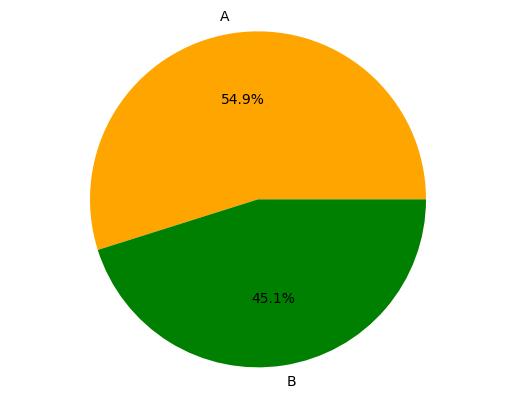

<Figure size 640x480 with 0 Axes>

In [30]:
# A pie chart for comparison
wedge_sizes = ad_clicks_pivot.percent_clicked
wedge_labels = ad_clicks_pivot.experimental_group

plt.pie(wedge_sizes, labels = wedge_labels, colors = ['orange','green'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()
plt.clf()

Dựa vào bảng tổng hợp và cả biểu đồ tròn, ta có thể thấy **quảng cáo A** có vẻ thu hút được nhiều người nhấp chuột truy cập hơn.

### Số lượt truy cập vào mỗi nhóm quảng cáo A và B có thay đổi trong tuần không?


Ta bắt đầu với việc tạo DataFrame `ad_clicks_by_day`biểu thị tổng số lượt truy cập quảng cáo của cả 2 nhóm A và B giữa các ngày trong tuần.

In [31]:
ad_clicks_by_day = ad_clicks.groupby('day')['is_click'].sum().reset_index()

In [32]:
ad_clicks_by_day

,day,is_click
0,1 - Monday,75
1,2 - Tuesday,88
2,3 - Wednesday,73
3,4 - Thursday,76
4,5 - Friday,89
5,6 - Saturday,87
6,7 - Sunday,77


Vẽ biểu đồ so sánh số lượt truy cập quảng cáo giữa các ngày.

/tmp/ipython-input-3856930968.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day', y='is_click', data=ad_clicks_by_day, palette=colors)


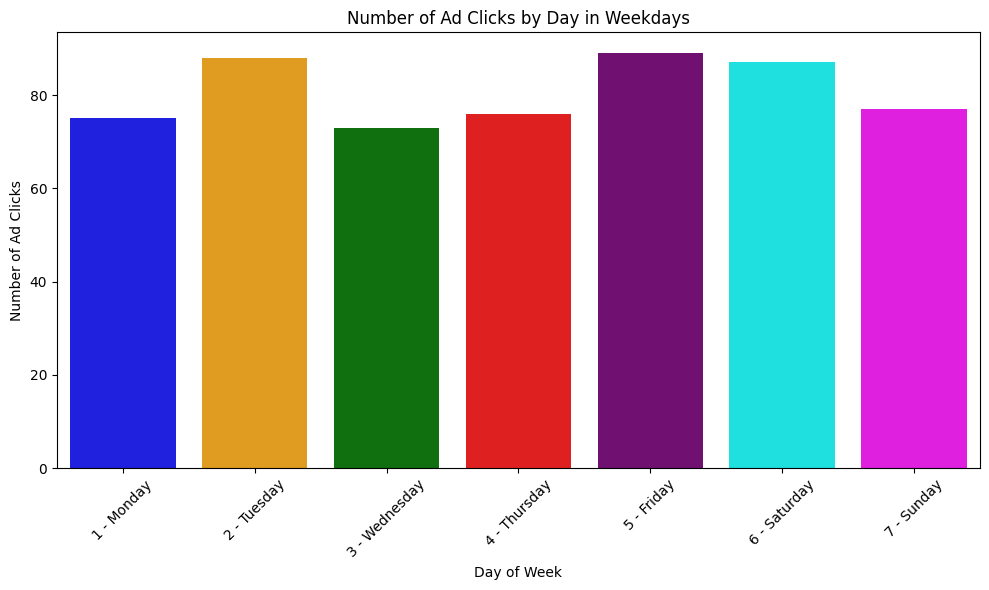

In [33]:
# Create a color palette for the bar plot
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta']

# Draw the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='day', y='is_click', data=ad_clicks_by_day, palette=colors)
plt.title('Number of Ad Clicks by Day in Weekdays')
plt.xlabel('Day of Week')
plt.ylabel('Number of Ad Clicks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Kiểm định One-way ANOVA**

Đặt giả thuyết $H_0$: Số lượng nhấp chuột truy cập quảng cáo ở cả 2 nhóm không thay đổi suốt tuần.

Ta sử dụng phương pháp Kiểm định One-way ANOVA (One-way Analysis of Variance), với mức ý nghĩa $\alpha=5\%=0.05$, với giả thuyết cần kiểm định là: $\mu_{Monday}=\mu_{Tuesday}=...=\mu_{Sunday}$.

In [34]:
f_statistic, p_value = stats.f_oneway(*[ad_clicks[ad_clicks['day'] == day]['is_click'] for day in ad_clicks_by_day['day']])
print(f'F-statistic: {f_statistic:.4f}')
print(f'p-value: {p_value:.4f}')

F-statistic: 0.7551
p-value: 0.6053


Do $p_{value}=0.6053>\alpha=0.05$ nên ta chưa đủ cơ sở bác bỏ giả thuyết H0. Vậy ta kết quả kiểm định cho thấy không có sự khác biệt đáng kể về số lượt truy cập quảng cáo ở cả 2 nhóm vào các ngày trong tuần.

### Tỷ lệ người dùng truy cập vào quảng cáo theo các ngày trong tuần

#### Nhóm quảng cáo A:

Ta sẽ bắt đầu với việc tạo DataFrame `a_clicks` chứa dữ liệu của các lần truy cập vào quảng cáo thuộc nhóm A.

In [35]:
a_clicks = ad_clicks[ad_clicks.experimental_group == 'A']
a_clicks.head()

,user_id,utm_source,day,ad_click_timestamp,experimental_group,is_click
0,008b7c6c-7272-471e-b90e-930d548bd8d7,google,6 - Saturday,07:18:00,A,True
2,00f5d532-ed58-4570-b6d2-768df5f41aed,twitter,2 - Tuesday,NaN,A,False
5,013b0072-7b72-40e7-b698-98b4d0c9967f,facebook,1 - Monday,NaN,A,False
6,0153d85b-7660-4c39-92eb-1e1acd023280,google,4 - Thursday,NaN,A,False
7,01555297-d6e6-49ae-aeba-1b196fdbb09f,google,3 - Wednesday,NaN,A,False


Dựa vào DataFrame `a_clicks`, ta sẽ tạo 1 bảng tổng hợp `a_clicks_pivot` biểu thị tỷ lệ truy cập vào quảng cáo ở nhóm A theo ngày.

In [36]:
a_clicks_pivot = a_clicks.groupby(['is_click', 'day']).user_id.count().reset_index()\
.pivot(
  index = 'day',
  columns = 'is_click',
  values = 'user_id'
).reset_index()\

# The click-through rate for A ad access
a_clicks_pivot['percent_clicked'] = a_clicks_pivot[True] / (a_clicks_pivot[True] + a_clicks_pivot[False])

In [37]:
a_clicks_pivot

is_click,day,False,True,percent_clicked
0,1 - Monday,70,43,0.380531
1,2 - Tuesday,76,43,0.361345
2,3 - Wednesday,86,38,0.306452
3,4 - Thursday,69,47,0.405172
4,5 - Friday,77,51,0.398438
5,6 - Saturday,73,45,0.381356
6,7 - Sunday,66,43,0.394495


#### Nhóm quảng cáo B:

Tương tự với nhóm quảng cáo B:

DataFrame `b_clicks` chứa dữ liệu của các lần truy cập vào quảng cáo thuộc nhóm B.

In [38]:
b_clicks = ad_clicks[ad_clicks.experimental_group == 'B']
b_clicks.head()

,user_id,utm_source,day,ad_click_timestamp,experimental_group,is_click
1,009abb94-5e14-4b6c-bb1c-4f4df7aa7557,facebook,7 - Sunday,NaN,B,False
3,011adc64-0f44-4fd9-a0bb-f1506d2ad439,google,2 - Tuesday,NaN,B,False
4,012137e6-7ae7-4649-af68-205b4702169c,facebook,7 - Sunday,NaN,B,False
9,01a210c3-fde0-4e6f-8efd-4f0e38730ae6,email,2 - Tuesday,15:21:00,B,True
10,01adb2e7-f711-4ae4-a7c6-29f48457eea1,google,3 - Wednesday,NaN,B,False


Bảng tổng hợp `b_clicks_pivot` biểu thị tỷ lệ truy cập vào quảng cáo ở nhóm B theo ngày.

In [39]:
b_clicks_pivot = b_clicks.groupby(['is_click', 'day']).user_id.count().reset_index()\
  .pivot(
    index = 'day',
    columns = 'is_click',
    values = 'user_id'
  ).reset_index()

# The click-through rate for B ad access
b_clicks_pivot['percent_clicked'] = b_clicks_pivot[True] / (b_clicks_pivot[True] + b_clicks_pivot[False])

In [40]:
b_clicks_pivot

is_click,day,False,True,percent_clicked
0,1 - Monday,81,32,0.283186
1,2 - Tuesday,74,45,0.378151
2,3 - Wednesday,89,35,0.282258
3,4 - Thursday,87,29,0.250000
4,5 - Friday,90,38,0.296875
5,6 - Saturday,76,42,0.355932
6,7 - Sunday,75,34,0.311927


### So sánh tỷ lệ truy cập quảng cáo giữa 2 nhóm A và B
Ta tạo một DataFrame `total_clicks_day` để so sánh tỷ lệ truy cập quảng cáo giữa 2 nhóm A và B.

In [41]:
total_clicks_day = pd.DataFrame()
total_clicks_day['day'] = a_clicks_pivot.day
total_clicks_day['A'] = a_clicks_pivot.percent_clicked
total_clicks_day['B'] = b_clicks_pivot.percent_clicked

In [42]:
total_clicks_day

,day,A,B
0,1 - Monday,0.380531,0.283186
1,2 - Tuesday,0.361345,0.378151
2,3 - Wednesday,0.306452,0.282258
3,4 - Thursday,0.405172,0.250000
4,5 - Friday,0.398438,0.296875
5,6 - Saturday,0.381356,0.355932
6,7 - Sunday,0.394495,0.311927


Ta sẽ dùng hàm `melt()` biến các cột A và B thành các giá trị dưới một cột mới tên `experiment` để thuận tiện cho việc vẽ biểu đồ.

In [43]:
transposed_df = pd.melt(total_clicks_day, id_vars=['day'], var_name='experiment', value_name='percent_clicked')

In [44]:
transposed_df

,day,experiment,percent_clicked
0,1 - Monday,A,0.380531
1,2 - Tuesday,A,0.361345
2,3 - Wednesday,A,0.306452
3,4 - Thursday,A,0.405172
4,5 - Friday,A,0.398438
5,6 - Saturday,A,0.381356
6,7 - Sunday,A,0.394495
7,1 - Monday,B,0.283186
8,2 - Tuesday,B,0.378151
9,3 - Wednesday,B,0.282258


Cuối cùng, ta vẽ biểu đồ so sánh tỷ lệ truy cập quảng cáo giữa 2 nhóm A và B vào các ngày trong tuần.

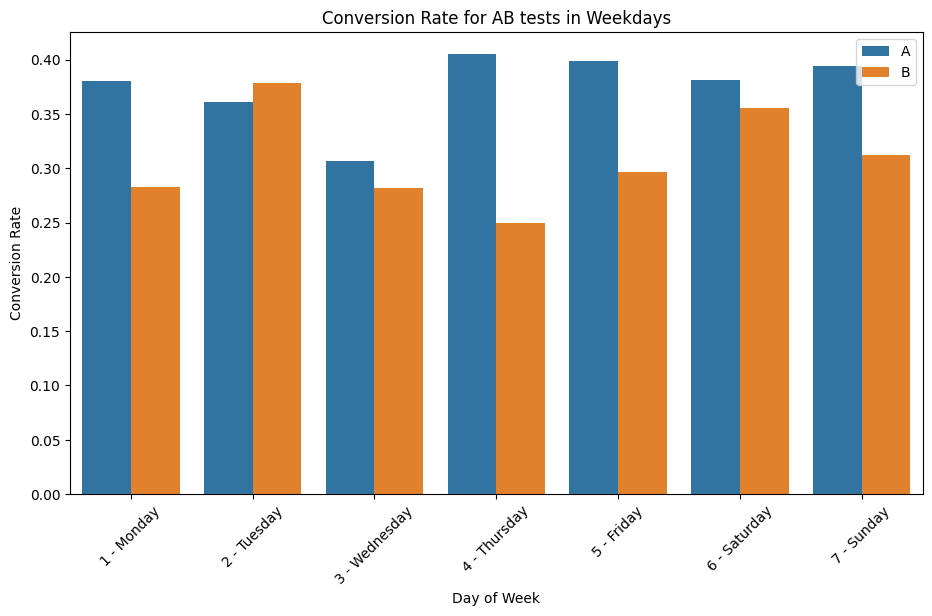

<Figure size 640x480 with 0 Axes>

In [45]:
plt.figure(figsize=(11,6))
sns.barplot(x = 'day', y = 'percent_clicked', hue = 'experiment', data = transposed_df)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate for AB tests in Weekdays')
plt.legend(loc='upper right')
plt.show()
plt.clf()

## KẾT LUẬN

Căn cứ vào những kết quả phân tích vừa rồi, ta có thể khẳng định một cách có ý nghĩa thống kê rằng **người dùng thường truy cập vào quảng cáo ở nhóm A nhiều hơn quảng cáo ở nhóm B vào hầu hết các ngày trong tuần** (trừ Thứ Ba). Nói cách khác, quảng cáo ở nhóm A thu hút được số lượng người nhấp chuột truy cập hơn so với quảng cáo B ở phần lớn thời gian trong tuần.

Mặt khác, nền tảng **facebook** thu hút được nhiều lượt truy cập nhất trong số 4 nền tảng đã triển khai trong chiến dịch quảng cáo. Do đó, để tối ưu hóa cho việc quảng cáo này, nhà bán lẻ nên tập trung vào **quảng cáo A trên nền tảng Facebook** nhiều hơn.

## TÀI LIỆU THAM KHẢO
- Các file bài giảng môn Python cho Khoa học dữ liệu của ThS. Hà Văn Thảo.
- Các file bài giảng môn Xử lý số liệu thống kê của TS. Tô Đức Khánh.
- Project tham khảo tại: *https://github.com/pedramsafaeifar/Ad_Clicks___AB_Testing*.
- Các tài liệu Python khác.